<a href="https://colab.research.google.com/github/andrewsiyoon/spiking-seRNN/blob/main/L1regularizedSNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install packages + versions -----

# conda init sesnn

# activate <environment_name>
# pip install snntorch == 0.5.3
# pip install 

In [ ]:
pip install snntorch 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.5/95.5 KB 4.4 MB/s eta 0:00:00


In [ ]:
#Imports -----

import torch, torch.nn as nn
import snntorch as snn
import random

In [ ]:
#Random seed -----

random.seed(100000) #Arbitrarily large number

In [ ]:
#Dataloading -----

batch_size = 128
data_path='/data/mnist'
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
#Load MNIST dataset -----

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

# #MNIST (without permissions)
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

# mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)
# mnist_test = datasets.MNIST(root = './', train=False, download=True, transform=transform)

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

#Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



In [ ]:
#Network architecture -----

from snntorch import surrogate
import torch.nn.functional as F

#Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        num_inputs = 784
        num_hidden = 1000
        num_outputs = 10
        spike_grad = surrogate.fast_sigmoid()

        #Heterogeneous membrane time constants: [0, 1)
        beta1 = torch.rand((num_hidden), dtype = torch.float)
        beta2 = torch.rand((num_outputs), dtype = torch.float) #.to(device)

        #Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta1, spike_grad=spike_grad, learn_beta=True)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta2, spike_grad=spike_grad,learn_beta=True)

    def forward(self, x):

        #Initialize hidden states and outputs
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        #Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x.flatten(1))
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec), torch.stack(mem2_rec)

#Load the network onto CUDA if available
net = Net().to(device)

#View model architecture
print(f"Model structure: {net}\n\n")

for name, param in net.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

print(torch.mean(net.fc1.weight))
print(torch.mean(net.fc2.weight))


# for param in net.parameters():
#     print(type(param), param.size())

Model structure: Net(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
  (lif2): Leaky()
)


Layer: fc1.weight | Size: torch.Size([1000, 784]) | Values : tensor([[-0.0095, -0.0073,  0.0186,  ..., -0.0274,  0.0227,  0.0169],
        [ 0.0082, -0.0281,  0.0065,  ...,  0.0006,  0.0146, -0.0082]],
       grad_fn=<SliceBackward0>) 

Layer: fc1.bias | Size: torch.Size([1000]) | Values : tensor([-0.0112,  0.0037], grad_fn=<SliceBackward0>) 

Layer: lif1.beta | Size: torch.Size([1000]) | Values : tensor([0.6043, 0.8213], grad_fn=<SliceBackward0>) 

Layer: fc2.weight | Size: torch.Size([10, 1000]) | Values : tensor([[ 1.1496e-02,  2.9592e-02,  3.0167e-02,  ...,  1.1874e-02,
         -6.4611e-03, -3.9901e-03],
        [-6.0509e-04, -1.3790e-05, -7.5737e-03,  ...,  2.6700e-02,
         -2.7972e-02,  1.8066e-03]], grad_fn=<SliceBackward0>) 

Layer: fc2.bias | Size: torch.Size([10]) | Values : tensor([0.01

In [ ]:
#Optimizer and loss function -----
import snntorch.functional as SF

optimizer = torch.optim.Adam(net.parameters(), lr = 2e-3, betas = (0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate = 0.8, incorrect_rate = 0.2)

In [ ]:
#Training loop -----
num_epochs = 10
num_steps = 25
counter = 0  

loss_hist = []
acc_hist = []
abs_mean = []

#Pre-training reports and calculations

layer1_init_weight = torch.mean(torch.abs(net.fc1.weight))
layer2_init_weight = torch.mean(torch.abs(net.fc2.weight))
print(f"Mean absolute weight of layer 1 is {layer1_init_weight}")
print(f"Mean absolute weight of layer 2 is {layer2_init_weight}")

abs_mean.append(layer1_init_weight.item() + layer2_init_weight.item())

for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(train_loader)):
        data = data.to(device)
        targets = targets.to(device)

        #Train the network
        net.train()
        spk_rec, _ = net(data) #spk_rec = "outputs" in other documents
        
        #L1 regularization
        layer1_reg = 1e-6 * torch.sum(torch.abs(net.fc1.weight)) #L1 loss on weight matrix of layer 1
        layer2_reg = 1e-6 * torch.sum(torch.abs(net.fc2.weight))
        loss_val = loss_fn(spk_rec, targets) + layer1_reg + layer2_reg

        # #No regularization
        # loss_val = loss_fn(spk_rec, targets)

        #Absolute mean of weights calculation
        layer1_mean_weights = torch.mean(torch.abs(net.fc1.weight)) 
        layer2_mean_weights = torch.mean(torch.abs(net.fc2.weight))

        mean_weights = layer1_mean_weights + layer2_mean_weights

        #Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        #Store loss history
        loss_hist.append(loss_val.item())

        #Store mean absolute weight history
        abs_mean.append(mean_weights.item())

        # print every 25 iterations
        if i % 25 == 0:
          net.eval()
          print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")
          print(mean_weights.item())

          # check accuracy on a single batch
          acc = SF.accuracy_rate(spk_rec, targets)
          acc_hist.append(acc)
          print(f"Accuracy: {acc * 100:.2f}%\n")

Mean absolute weight of layer 1 is 0.01787295565009117
Mean absolute weight of layer 2 is 0.015787139534950256
Epoch 0, Iteration 0 
Train Loss: 2.51
0.03366009518504143
Accuracy: 12.50%

Epoch 0, Iteration 25 
Train Loss: 0.60
0.014429347589612007
Accuracy: 75.78%

Epoch 0, Iteration 50 
Train Loss: 0.38
0.012453729286789894
Accuracy: 89.06%

Epoch 0, Iteration 75 
Train Loss: 0.25
0.011747833341360092
Accuracy: 93.75%

Epoch 0, Iteration 100 
Train Loss: 0.23
0.011332005262374878
Accuracy: 92.97%

Epoch 0, Iteration 125 
Train Loss: 0.24
0.01102922111749649
Accuracy: 88.28%

Epoch 0, Iteration 150 
Train Loss: 0.18
0.01078788936138153
Accuracy: 95.31%

Epoch 0, Iteration 175 
Train Loss: 0.22
0.010546806268393993
Accuracy: 92.97%

Epoch 0, Iteration 200 
Train Loss: 0.19
0.010297322645783424
Accuracy: 93.75%

Epoch 0, Iteration 225 
Train Loss: 0.23
0.010102622210979462
Accuracy: 90.62%

Epoch 0, Iteration 250 
Train Loss: 0.18
0.00991714745759964
Accuracy: 91.41%

Epoch 0, Iteration

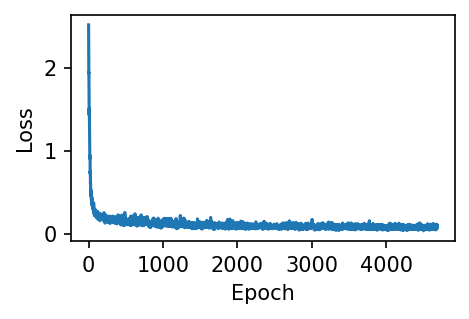

In [ ]:
#Visualize loss -----

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('lossreg1.png')

Text(0, 0.5, 'Mean absolute weight')

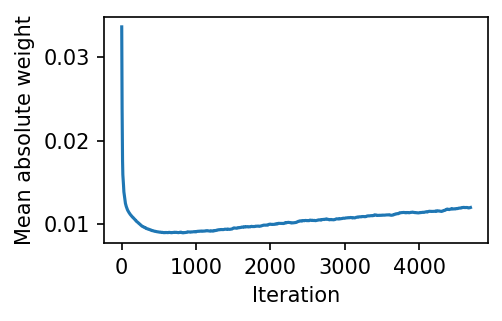

In [ ]:
#Visualize mean absolute weight

plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(abs_mean[1:])
plt.xlabel("Iteration")
plt.ylabel("Mean absolute weight")

Text(0, 0.5, 'Accuracy')

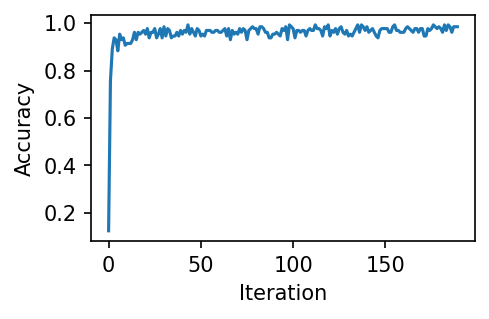

In [ ]:
#Visualize accuracy/performance

plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(acc_hist)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")